# Topic Modeling 

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. In our case, extracting the topics of product reviews can be useful to companies that sell products, who can use these results to improve their products, increase both sales and customer experiences.

Since it's really hard to manually read through such large volumes and compile the topics, it is important to find a way to do this in an automated way. In this notebook we therefore want to pursue this task to extract the main topics present in the negative reviews in our dataset. We focus on negative reviews because we believe that it is more interesting for companies selling products to understand why a negative review is negative than to know why a positive review is positive.

## Import Libraries

In [16]:
import pandas as pd
import numpy as np
import os
import sys
from pprint import pprint
import re
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# spacy for lemmatization
import spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

## Load Dataset

We now proceed to load the dataset we will be working with and save it in the DataFrame `df`. 

In [17]:
#Get the directory of the script
script_directory = os.getcwd()
data_name="../Final_Dataset/Dataset_final.csv"
#Combine the script directory and folder name to get the full path
data_path = os.path.join(script_directory, data_name)

df=pd.read_csv(data_path)

We delete the `title` column, as we will only work with entire product reviews. We do this because the titles alone are not long enough to extract interesting topics. Entire reviews are longer and more detailed, and allow us to make a more meaningful distinction of topics. Then we only focus on data that have `polarity` equal to 1. In fact, as explained in the introduction, our study will only focus on negative reviews.

In [18]:
# Drop the 'title' column from the DataFrame
df = df.drop(columns="title")
# Filter the DataFrame to include only 'polarity' equal to 1 rows
df = df[df.polarity == 1]


In [19]:
df.head()

polarity                                               text
0         1  these looked really nice, but they had this we...
1         1  i agree with buyers who say that the product i...
2         1  i bought this for my wife for christmas and sh...
3         1  this bra is definitely not what i was hoping f...
4         1  normally i would slap someone who said what i ...

We check that there are no null data.

In [20]:
df.isna().sum()

polarity    0
text        0
dtype: int64

## Text Prepocessing

In this section we begin to pre-process the text data, so that it is ready for the application of the `LDA (Latent Dirichlet Allocation)` algorithm which we will use to identify the various topics.

### Text Cleaning

We begin by defining the `preprocess_senteces` function, which is responsible for this conversion: it strips out email addresses, spacing characters and single quotes, splits the text into words using Gensim's `simple_preprocess` function, and removes the punctuations.

In [31]:
def preprocess_senteces(sentences):
    '''
    Function to preprocess sentences by removing emails, newline characters, and single quotes,
    and then tokenize the sentences into words using Gensim's simple_preprocess.

    Parameters:
    - sentences: List of sentences to preprocess.

    Yields:
    - List of words for each sentence after preprocessing.
    '''
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)
        sent = re.sub('\s+', ' ', sent)
        sent = re.sub("\'", "", sent)
        
        # Tokenize the sentence into words
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) # deacc=True removes punctuations
        
        yield sent


At this point, we convert the text of the reviews into a list of words. This is important because LDA operates on a word-based representation of the text. We then pass each review through the `preprocess_sentences` function.

In [32]:
# Convert the 'text' column of the DataFrame to a list
data = df.text.values.tolist()
pprint(data[:1])


['these looked really nice, but they had this weird wood smell, so i returned '
 "them. i own a clear plastic olde thompson set, which i've had for years, but "
 'the pepper mill broke. the company sent me a new pepper mill since there is '
 'a lifetime warranty. great experience with olde thompson, just not with this '
 'particular product.']


In [33]:
# Convert the text data into words using the sent_to_words function
data_words = list(preprocess_senteces(data))
pprint(data_words[:1])


[['these',
  'looked',
  'really',
  'nice',
  'but',
  'they',
  'had',
  'this',
  'weird',
  'wood',
  'smell',
  'so',
  'returned',
  'them',
  'own',
  'clear',
  'plastic',
  'olde',
  'thompson',
  'set',
  'which',
  'ive',
  'had',
  'for',
  'years',
  'but',
  'the',
  'pepper',
  'mill',
  'broke',
  'the',
  'company',
  'sent',
  'me',
  'new',
  'pepper',
  'mill',
  'since',
  'there',
  'is',
  'lifetime',
  'warranty',
  'great',
  'experience',
  'with',
  'olde',
  'thompson',
  'just',
  'not',
  'with',
  'this',
  'particular',
  'product']]


### Create Bigram and Trigram Models

We now construct models of bigrams and trigrams for our text corpus. These models identify common phrases of two and three words respectively. We use `Phraser` objects to efficiently apply the models to our documents. The two important arguments to Phrases are `min_count` and `threshold`. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [34]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Create a Phraser object for the bigram and trigram models 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [36]:
pprint(trigram_mod[bigram_mod[data_words[0]]])

['these',
 'looked',
 'really',
 'nice',
 'but',
 'they',
 'had',
 'this',
 'weird',
 'wood',
 'smell',
 'so',
 'returned',
 'them',
 'own',
 'clear',
 'plastic',
 'olde',
 'thompson',
 'set',
 'which',
 'ive',
 'had',
 'for',
 'years',
 'but',
 'the',
 'pepper_mill',
 'broke',
 'the',
 'company',
 'sent',
 'me',
 'new',
 'pepper_mill',
 'since',
 'there',
 'is',
 'lifetime_warranty',
 'great',
 'experience',
 'with',
 'olde',
 'thompson',
 'just',
 'not',
 'with',
 'this',
 'particular',
 'product']


### Stopwords, Bigrams and Lemmatization

Finally, we define several functions to process our text data before applying topic modelling algorithms. The `remove_stopwords` function removes the stop words from each document in the text list, returning a list of documents without the stop words. The `make_bigrams` function generates bigrams for each document in the text list using the previously created bigram template. Similarly, the `make_trigrams` function generates trigrams for each document using both the biggrams model and the trigrams model.

We then define the `lemmatization` function, which lemmatises documents by retaining only the specified part-of-speech tags (in this case nouns, adjectives, verbs and adverbs). This function uses the `spaCy` model to process each sentence and returns a list of lemmatised documents.

These operations allow us to prepare our text data efficiently for subsequent analysis, such as the application of the `Latent Dirichlet Allocation (LDA)` algorithm for topic modelling.

In [37]:
def remove_stopwords(texts):
    '''
    Remove stopwords from each document in the list of texts.
    Parameters:
        texts: List of documents where each document is a list of words
    Returns:
        List of documents with stopwords removed
    '''
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [38]:
def make_bigrams(texts):
    '''
    Generate bigrams for each document in the list of texts using the bigram model.
    Parameters:
        texts: List of documents where each document is a list of words
    Returns:
        List of documents with bigrams generated
    '''
    return [bigram_mod[doc] for doc in texts]

In [39]:
def make_trigrams(texts):
    '''
    Generate trigrams for each document in the list of texts using both the bigram and trigram models.
    Parameters:
        texts: List of documents where each document is a list of words
    Returns:
        List of documents with trigrams generated
    '''
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [40]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''
    Lemmatize the documents, keeping only the specified part-of-speech tags.
    Parameters:
        texts: List of documents where each document is a list of words
        allowed_postags: List of part-of-speech tags to keep after lemmatization
    Returns:
        texts_out: List of lemmatized documents
    '''
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))  # Process the sentence with spaCy
        # Append the lemmatized tokens to the output list if their POS tag is in allowed_postags
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [43]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [45]:
pprint(data_lemmatized[:1])

[['look',
  'really',
  'nice',
  'weird',
  'wood',
  'smell',
  'return',
  'clear',
  'plastic',
  'thompson',
  'set',
  've',
  'year',
  'pepper_mill',
  'broke',
  'company',
  'send',
  'new',
  'pepper_mill',
  'lifetime_warranty',
  'great',
  'experience',
  'particular',
  'product']]


## Build Topic Model

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.071*"book" + 0.026*"read" + 0.024*"movie" + 0.013*"story" + 0.012*"write" '
  '+ 0.011*"character" + 0.011*"author" + 0.010*"find" + 0.010*"give" + '
  '0.008*"page"'),
 (1,
  '0.025*"money" + 0.022*"bad" + 0.022*"thing" + 0.022*"buy" + 0.022*"time" + '
  '0.017*"never" + 0.016*"waste" + 0.015*"really" + 0.014*"song" + '
  '0.014*"old"'),
 (2,
  '0.027*"well" + 0.016*"much" + 0.012*"sound" + 0.012*"game" + 0.012*"film" + '
  '0.011*"music" + 0.011*"play" + 0.011*"great" + 0.010*"recommend" + '
  '0.009*"really"'),
 (3,
  '0.021*"work" + 0.019*"buy" + 0.018*"product" + 0.012*"purchase" + '
  '0.009*"return" + 0.009*"problem" + 0.008*"order" + 0.008*"set" + '
  '0.008*"time" + 0.007*"back"')]


In [34]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Crea un DataFrame temporaneo e concatena
                temp_df = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], 
                                       columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
                sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)
            else:
                break
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [35]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               3              0.7183   
1            1               1              0.4728   
2            2               1              0.6926   
3            3               2              0.7983   
4            4               2              0.7290   
5            5               0              0.6440   
6            6               1              0.6521   
7            7               3              0.7097   
8            8               3              0.8018   
9            9               3              0.5673   

                                            Keywords  \
0  work, buy, product, purchase, return, problem,...   
1  money, bad, thing, buy, time, never, waste, re...   
2  money, bad, thing, buy, time, never, waste, re...   
3  well, much, sound, game, film, music, play, gr...   
4  well, much, sound, game, film, music, play, gr...   
5  book, read, movie, story, write, character, au...   
6  money, bad, thing, buy, time, never, waste, re...   
7  work, buy, product, purchase, return, problem,...   
8  work, buy, product, purchase, return, problem,...   
9  work, buy, product, purchase, return, problem,...   

                                                Text  
0  [look, really, weird, wood, smell, return, cle...  
1  [agree, buyer, product, replace, neck, pillow,...  
2  [buy, disappointed, smell, smell, beautiful, o...  
3  [bra, definitely, hope, supportive, thin, mate...  
4  [normally, slap, title, film, deserve, restore...  
5  [disappoint, book, hail, proust, find, depth, ...  
6  [reason, hillman, stand, band, singe, group, b...  
7  [welllook, sucker, writen, face, todead, door,...  
8  [fit, office, patrician, fit, floor, look, stu...  
9  [buy, law, work, great, home, tall, gate, brin...

In [36]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0          0              0.9640   
1          1              0.9462   
2          2              0.9387   
3          3              0.9816   

                                                                Keywords  \
0   book, read, movie, story, write, character, author, find, give, page   
1          money, bad, thing, buy, time, never, waste, really, song, old   
2   well, much, sound, game, film, music, play, great, recommend, really   
3  work, buy, product, purchase, return, problem, order, set, time, back   

                                                                                   Representative Text  
0  [book, part, give, mentality, prevalent, culture, unfortunately, church, incredibly, sexist, lon...  
1                   [people, fool, big, fan, bother, punk, punk, real, punk, band, dollar, song, punk]  
2  [unimpressed, video, short, wing_chun, basic, look, learn, videotape, look, augustine, fong, ins...  
3  [purchase, slot, toaster, egg_cooker, slot, toaster, egg_cooker, first, appliance, work, egg, me...

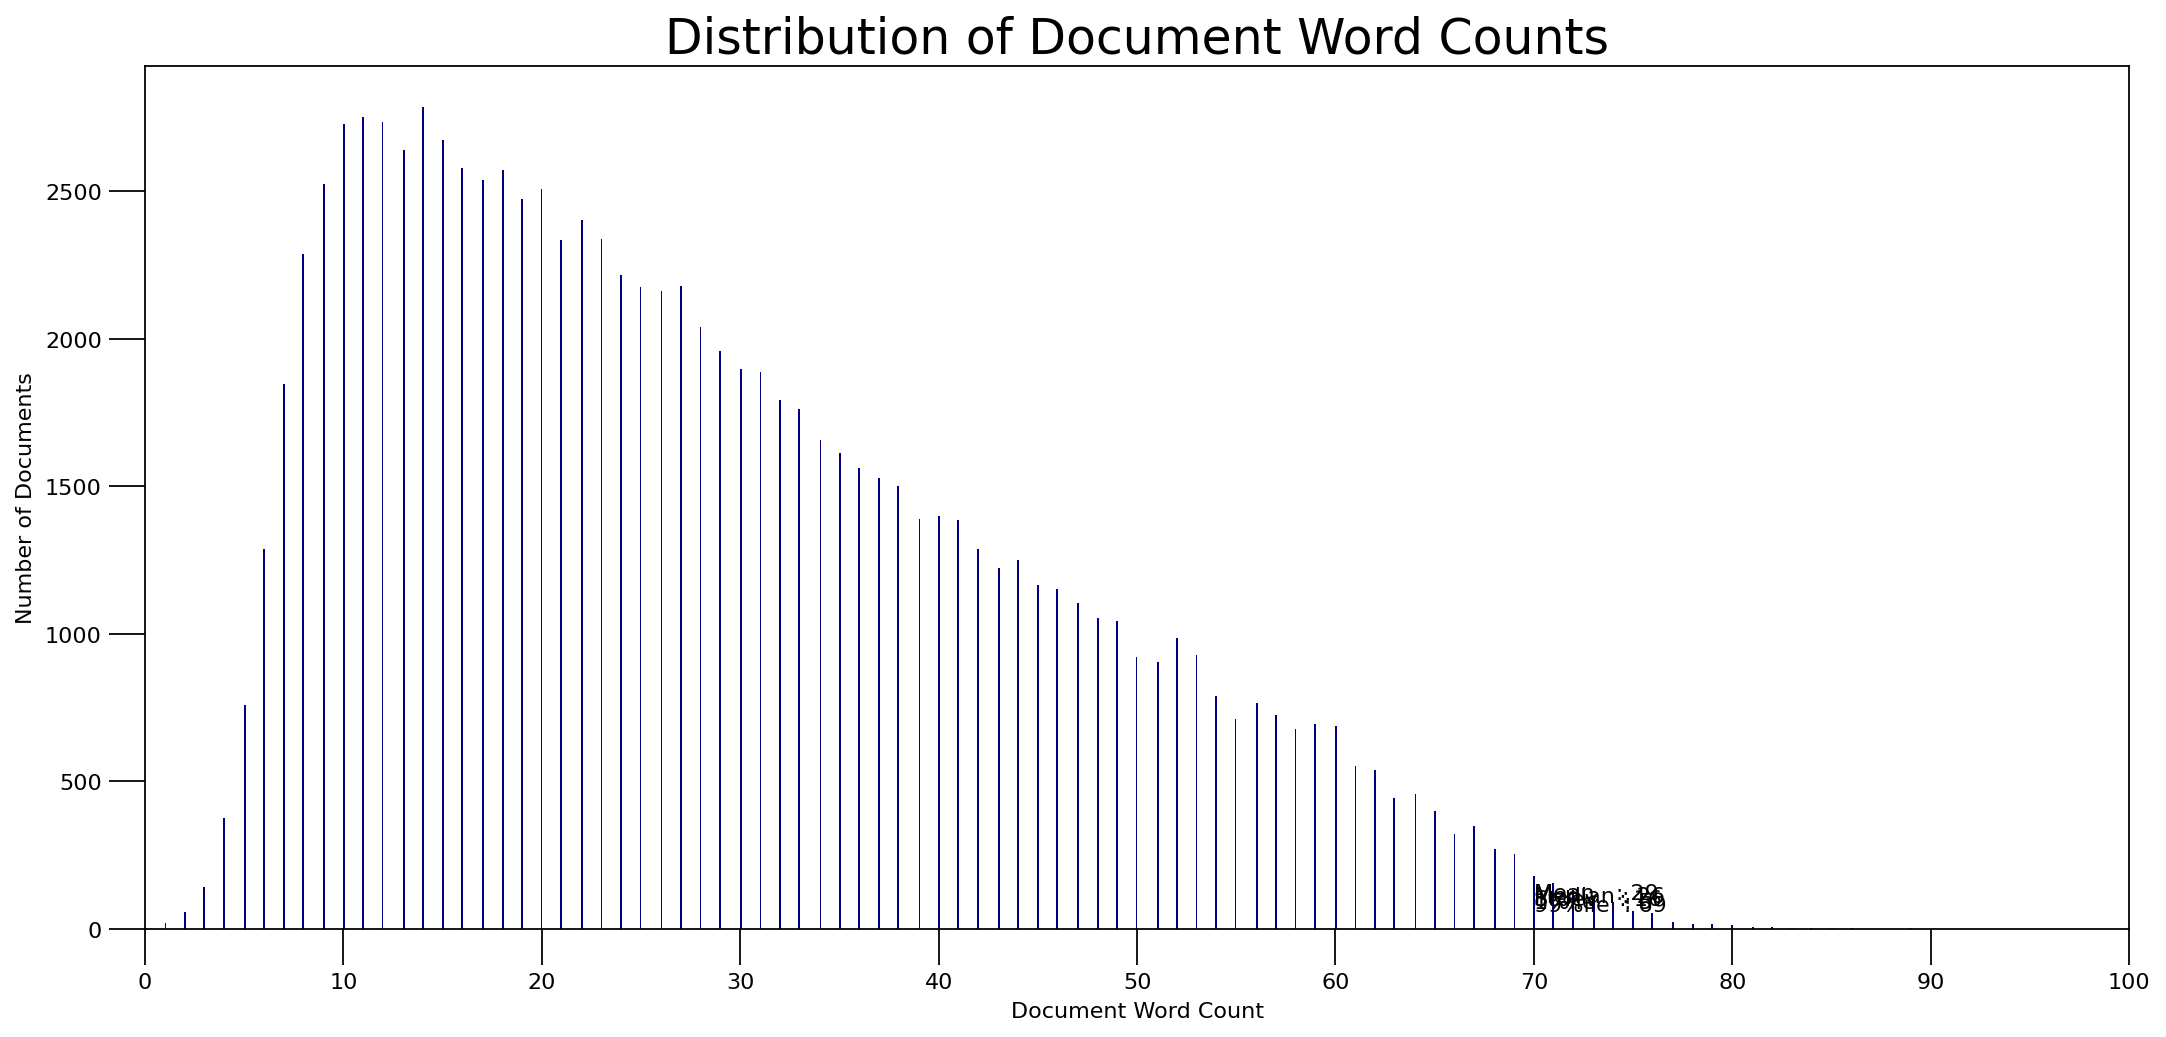

In [47]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins=1000, color='navy')
plt.text(70, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70, 90, "Median : " + str(round(np.median(doc_lens))))
plt.text(70, 80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70, 70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70, 60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 100, 11))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()



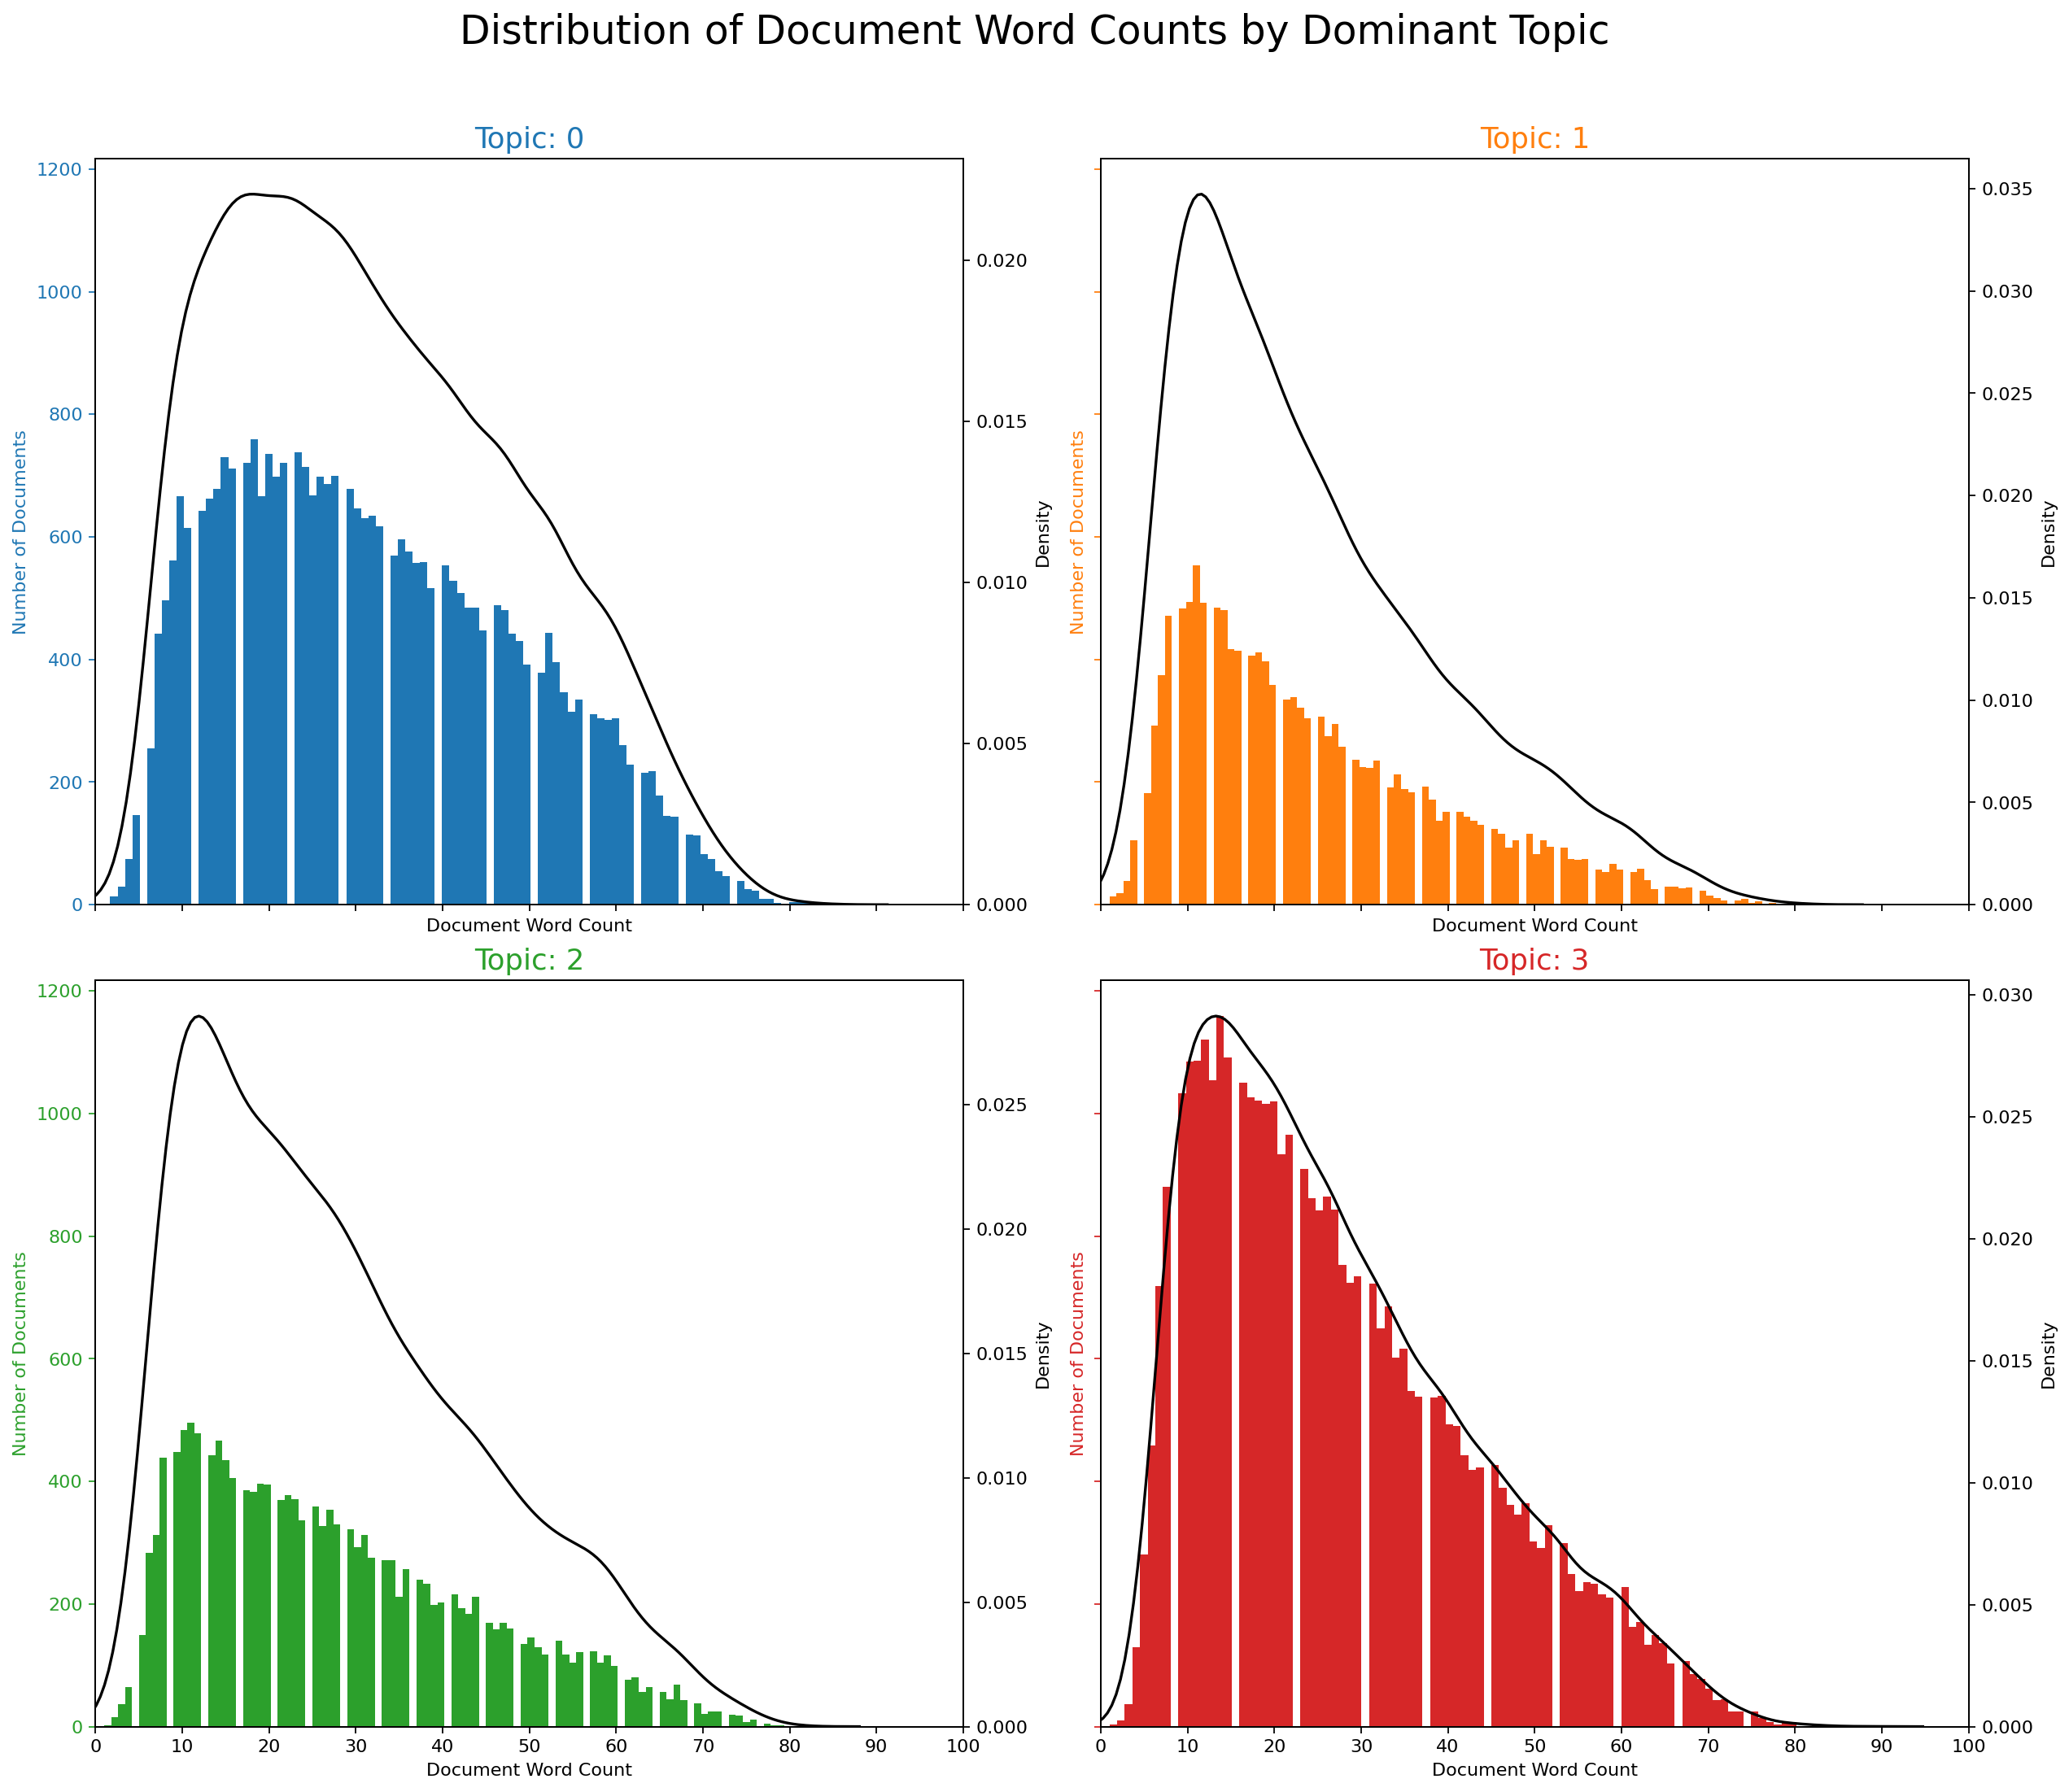

In [49]:
import seaborn as sns
import matplotlib.colors as mcolors

# Ottieni una lista di colori dalla tavolozza TABLEAU_COLORS
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Crea una figura con 4 subplot disposti in una griglia 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

# Itera attraverso ciascun asse
for i, ax in enumerate(axes.flatten()):    
    # Filtra i documenti per il topic dominante corrente
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    
    # Istogramma della lunghezza dei documenti
    ax.hist(doc_lens, bins=100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    
    # Grafico KDE (Kernel Density Estimate)
    sns.kdeplot(doc_lens, color="black", fill=False, ax=ax.twinx())
    
    # Imposta i limiti dell'asse x a 0-100
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: ' + str(i), fontdict=dict(size=16, color=cols[i]))

# Layout e impostazioni della figura
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0, 100, 11))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()


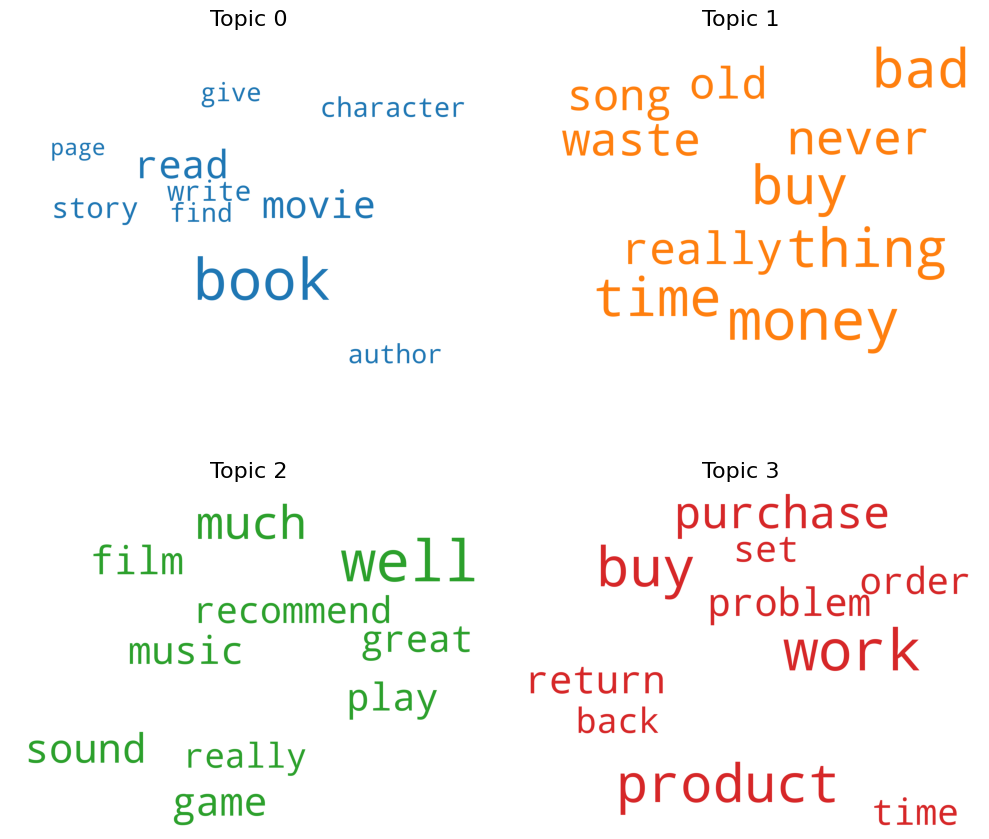

In [50]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

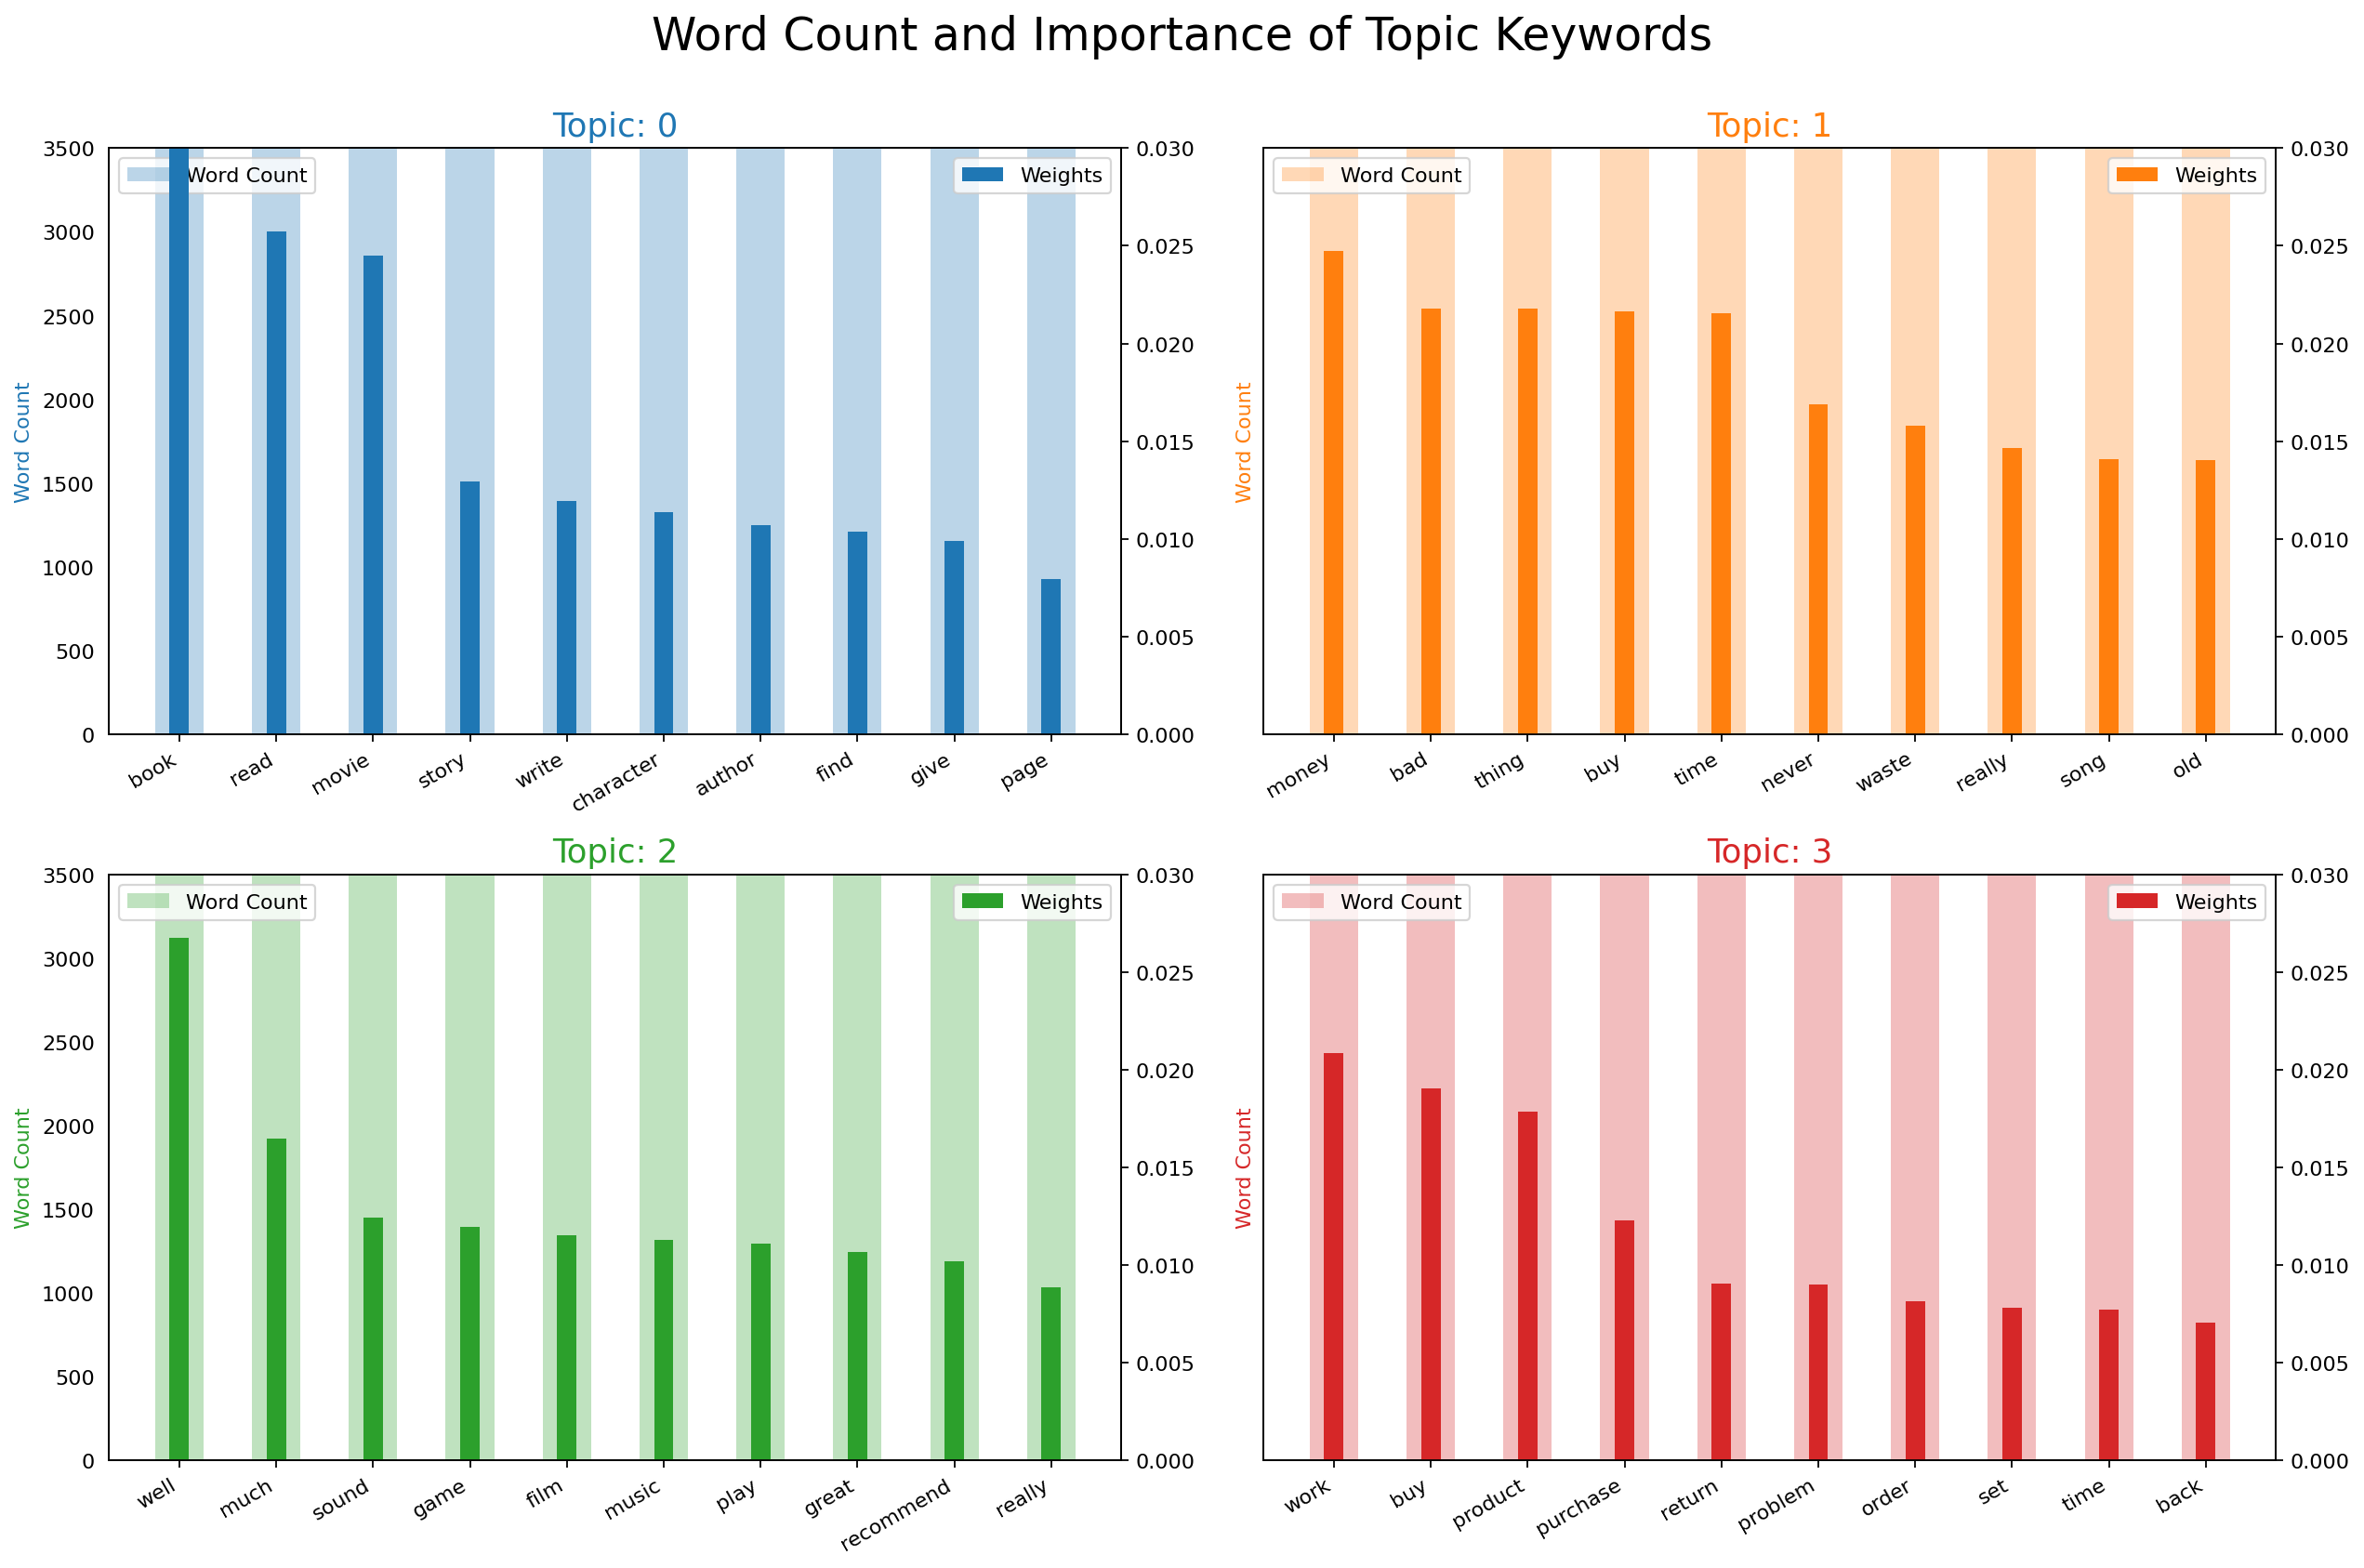

In [53]:
from collections import Counter


# Ottieni i topic dall'lda_model
topics = lda_model.show_topics(formatted=False)

# Unisci tutte le parole in una lista piatta
data_flat = [w for w_list in data_ready for w in w_list]

# Conta la frequenza delle parole
counter = Counter(data_flat)

# Crea un DataFrame con le parole, i topic, l'importanza e il conteggio delle parole
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot del conteggio delle parole e dei pesi delle parole chiave dei topic
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    df_topic = df.loc[df.topic_id == i, :]
    
    # Istogramma del conteggio delle parole
    ax.bar(x='word', height="word_count", data=df_topic, color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    # Istogramma dell'importanza delle parole
    ax_twin.bar(x='word', height="importance", data=df_topic, color=cols[i], width=0.2, label='Weights')
    
    # Imposta le etichette degli assi
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030)
    ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    
    # Imposta i tick e le etichette degli assi x
    ax.set_xticks(range(len(df_topic['word'])))
    ax.set_xticklabels(df_topic['word'], rotation=30, horizontalalignment='right')
    
    ax.tick_params(axis='y', left=False)
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')

# Layout della figura
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

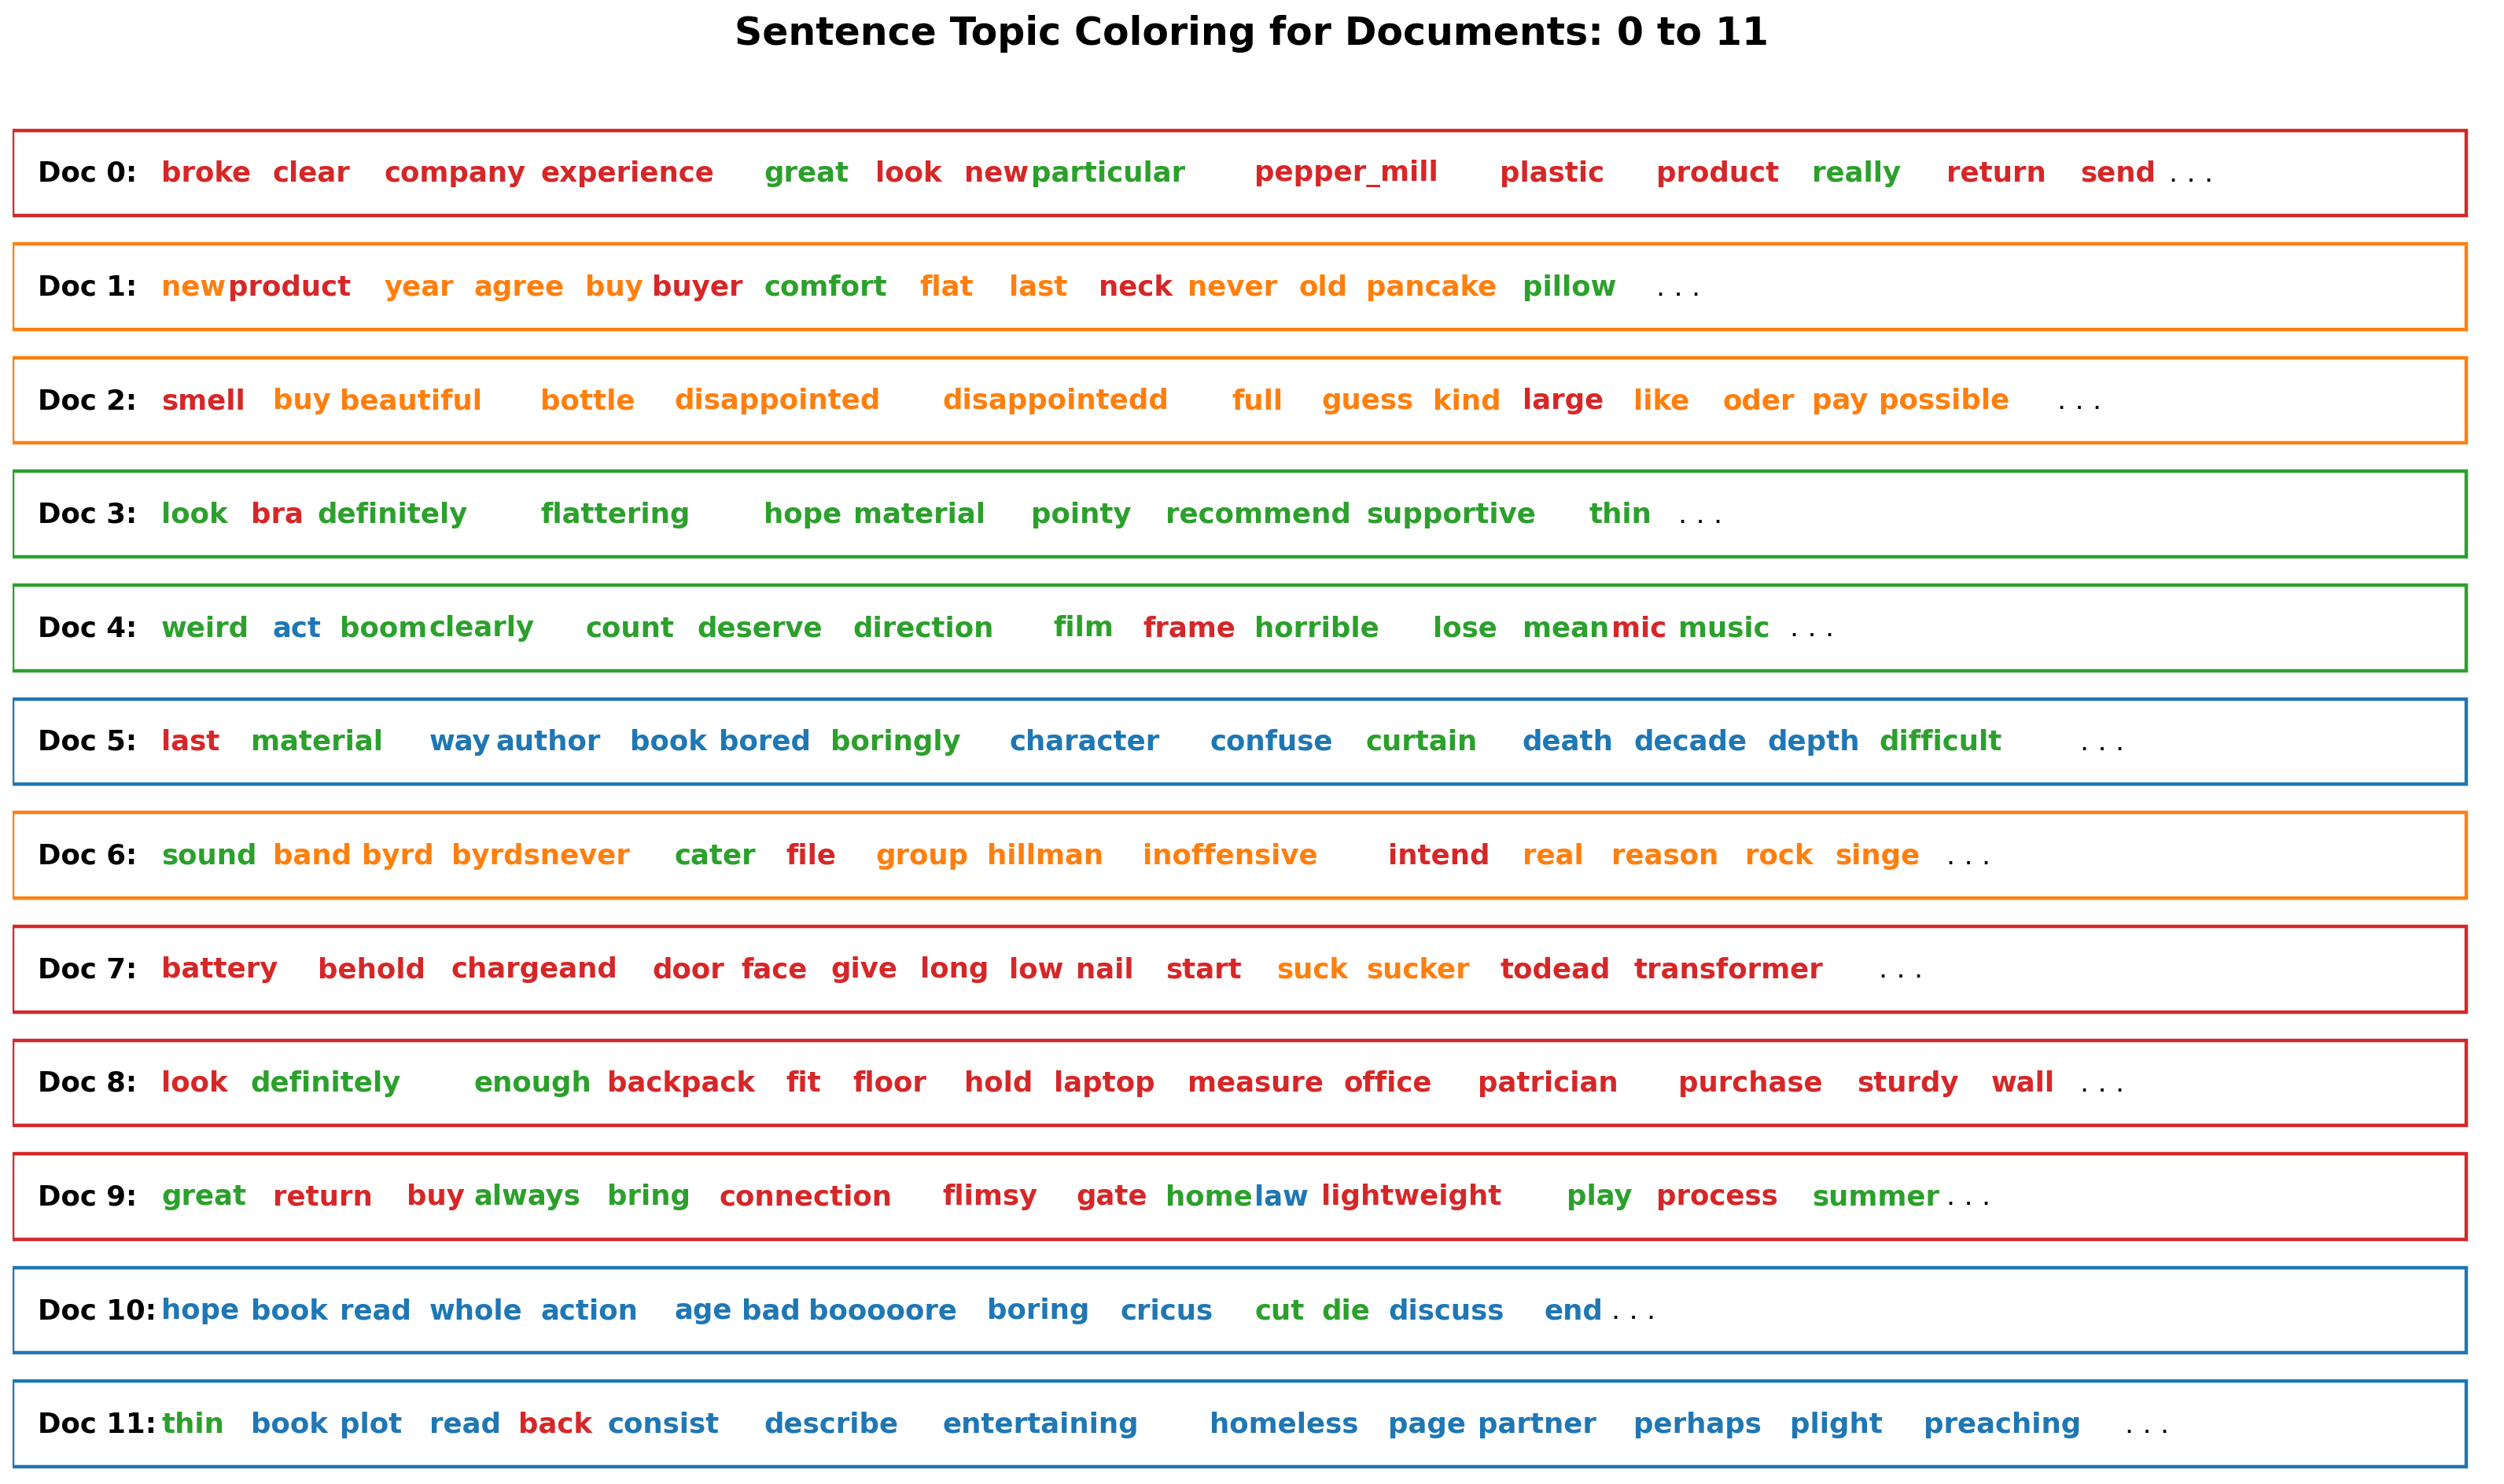

In [54]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [55]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

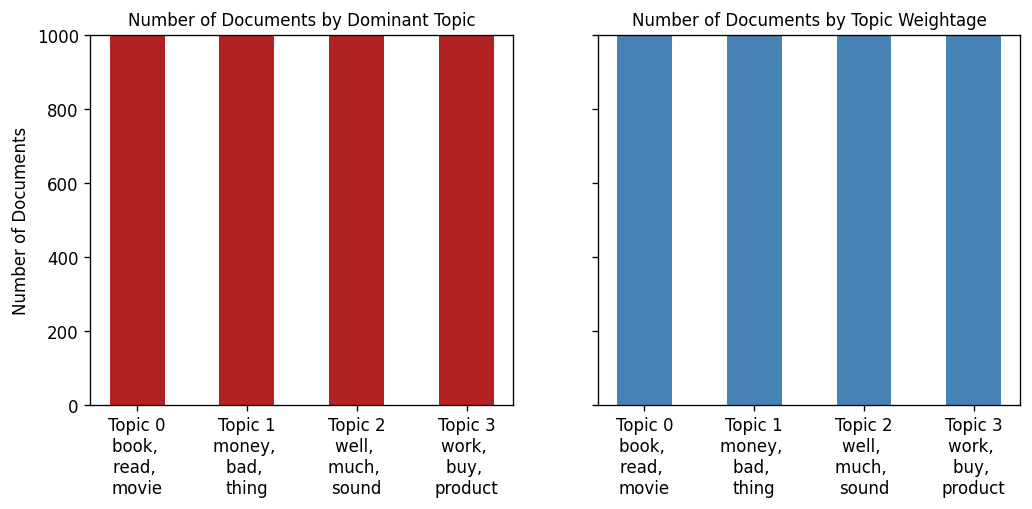

In [56]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [61]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 95885 samples in 0.019s...
[t-SNE] Computed neighbors for 95885 samples in 1.405s...
[t-SNE] Computed conditional probabilities for sample 1000 / 95885
[t-SNE] Computed conditional probabilities for sample 2000 / 95885
[t-SNE] Computed conditional probabilities for sample 3000 / 95885
[t-SNE] Computed conditional probabilities for sample 4000 / 95885
[t-SNE] Computed conditional probabilities for sample 5000 / 95885
[t-SNE] Computed conditional probabilities for sample 6000 / 95885
[t-SNE] Computed conditional probabilities for sample 7000 / 95885
[t-SNE] Computed conditional probabilities for sample 8000 / 95885
[t-SNE] Computed conditional probabilities for sample 9000 / 95885
[t-SNE] Computed conditional probabilities for sample 10000 / 95885
[t-SNE] Computed conditional probabilities for sample 11000 / 95885
[t-SNE] Computed conditional probabilities for sample 12000 / 95885
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [60]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.100762  0.227882       1        1  28.247346
0     -0.080710 -0.300533       2        1  26.913528
2     -0.296734  0.117401       3        1  24.358582
1      0.276681 -0.044750       4        1  20.480543, topic_info=      Term          Freq         Total Category  logprob  loglift
80    book  54753.000000  54753.000000  Default  30.0000  30.0000
119   read  19853.000000  19853.000000  Default  29.0000  29.0000
399  movie  18894.000000  18894.000000  Default  28.0000  28.0000
419  money  14534.000000  14534.000000  Default  27.0000  27.0000
183   well  21377.000000  21377.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
327  first   5920.126348  14217.891050   Topic4  -4.5968   0.7096
352  watch   4124.920492   7847.389416   Topic4  -4.9581   0.9426
421  spend   3389.475865   4916.850876   Topic4  -5.1545   1.2137
25    last   3342.573091   5632.978924   Topic4  -5.1684   1.0638
212   back   3490.536883   9203.441028   Topic4  -5.1251   0.6162

[211 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
57        2  0.999363     act
702       4  0.999852   album
170       3  0.999734  always
1155      1  0.999696  amazon
79        2  0.999868  author
...     ...       ...     ...
210       2  0.999668   world
459       2  0.999894   write
739       2  0.999816  writer
19        1  0.420853    year
19        4  0.579136    year

[219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])